# Time Series Prediction Using Arima

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('/Users/nathan/Desktop/baggagecomplaints.csv')
data.Date = pd.to_datetime(data.Date)
data.head(3)

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,2004-01-01,1,2004,12502,38276,2481,992360
1,American Eagle,2004-02-01,2,2004,8977,35762,886,1060618
2,American Eagle,2004-03-01,3,2004,10289,39445,1346,1227469


## Some First Analysis

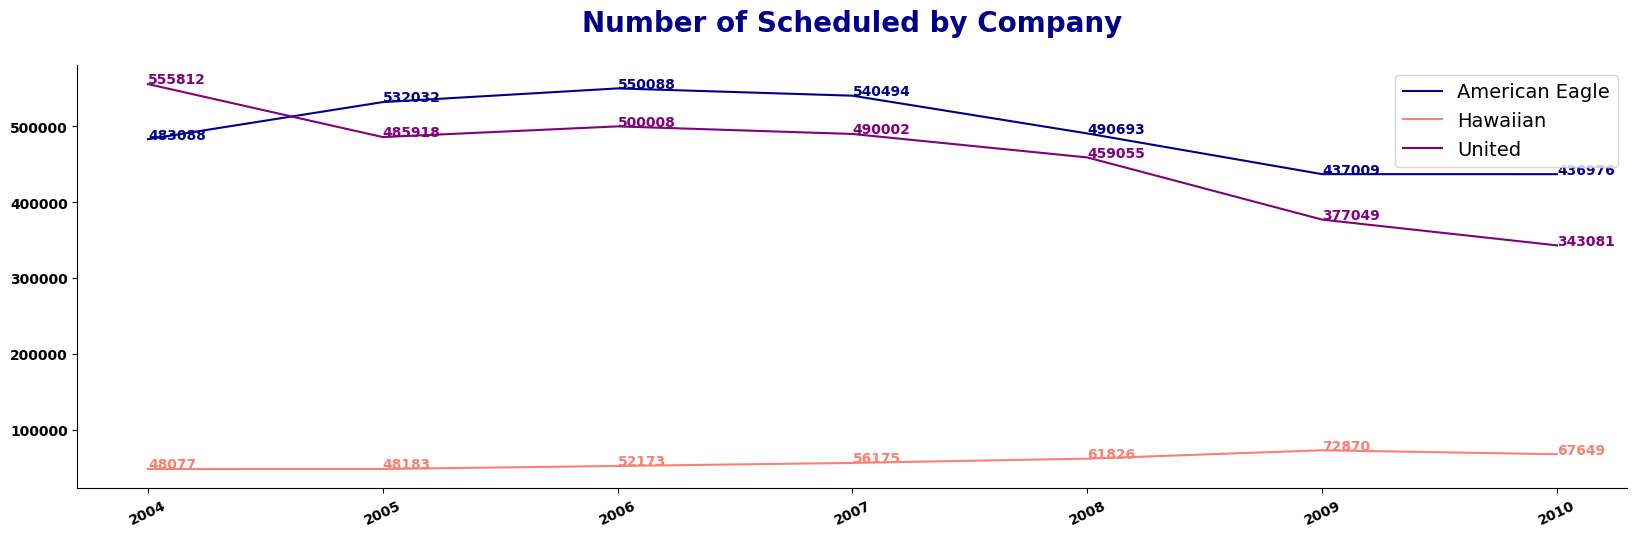

In [2]:
def plot_reason(reason):
    '''
    Fonction that return graph for any possible reason (Baggage, Scheduled, Cancelled, Enplaned)
    '''
    plt.figure(figsize=(20, 5.5))
    color = ['darkblue', 'salmon', 'purple']
    z = 0
    for element in data.Airline.unique():
        c_color = color[z]
        data2 = data[data.Airline == element]
        cancelled = data2.groupby(['Year'])[reason].sum().reset_index()
        cancelled = cancelled.rename(columns = {reason : 'Cancelled'})
        plt.plot(cancelled.Year, cancelled.Cancelled, label = element, color = c_color)

        for i, j in zip(cancelled.Year, cancelled.Cancelled):
            plt.annotate(j, xy = (i, j + 700), fontweight = 'bold', color = c_color)
        z +=1

    plt.legend(loc = 0, frameon = True, fontsize = 14)
    plt.title(f'Number of {reason} by Company', fontsize = 20, color = 'darkblue', fontweight = 'bold', y = 1.06)
    plt.xticks(fontweight = 'bold', rotation = 25)
    plt.yticks(fontweight = 'bold')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    
lst_reason = data.columns[4:].tolist()
random.shuffle(lst_reason)   # plotting random reason

# to show all plot in the same time -> I put 'next' for this time (just seeing the first one than come randomaly). Similar than break in loop    
next(plot_reason(reason) for reason in lst_reason)

In [3]:
from collections import Counter
# Year of min of any reason for each company

def minmim_year(reason, status = 'MAX') -> str:
    '''
    Return the min/max number for each reason 
    ''' 
    
    if status not in ["MIN", "MAX"]:
        raise ValueError("Invalid status. Status must be 'MIN' or 'MAX'.")
        
    lst_year = []
    for company in data.Airline.unique():
        united = data[data.Airline == company]
        min_cancelled = united.groupby('Year')[reason].mean().reset_index()
        
        if status == 'MIN':
        
            minimum = min_cancelled[min_cancelled[reason] == min(min_cancelled[reason])]
            print(f"For the {company} Company, the year that recorded the minimum number of {reason} "
                  f"was in {minimum['Year'].values[0]}, with a total of {int(minimum[reason].values[0]):,} {reason}.")

            lst_year.append(minimum.Year.values[0])
                        
        else:
            
            minimum = min_cancelled[min_cancelled[reason] == max(min_cancelled[reason])]
            print(f"For the {company} Company, the year that recorded the maximum number of cancellations was {reason} is in {minimum['Year'].values[0]}"
                  f", with a total of {int(minimum[reason].values[0]):,} {reason}.")
            lst_year.append(minimum.Year.values[0])
    
    print()
    dict_year = Counter(lst_year)
    for i, j in dict_year.items():
        print(f'For the year {i}: {j} companie/s has the {status} of {reason}')
        
        

# input the reason and the status that you need -> min/max
minmim_year('Cancelled', status = 'MIN')

For the American Eagle Company, the year that recorded the minimum number of Cancelled was in 2009, with a total of 926 Cancelled.
For the Hawaiian Company, the year that recorded the minimum number of Cancelled was in 2010, with a total of 5 Cancelled.
For the United Company, the year that recorded the minimum number of Cancelled was in 2010, with a total of 417 Cancelled.

For the year 2009: 1 companie/s has the MIN of Cancelled
For the year 2010: 2 companie/s has the MIN of Cancelled


# Arima Model

In [4]:
united = data[data.Airline == 'United'][['Date', 'Cancelled']].reset_index(drop = True)
united.head()

,Date,Cancelled
0,2004-01-01,1017
1,2004-02-01,312
2,2004-03-01,321
3,2004-04-01,162
4,2004-05-01,652


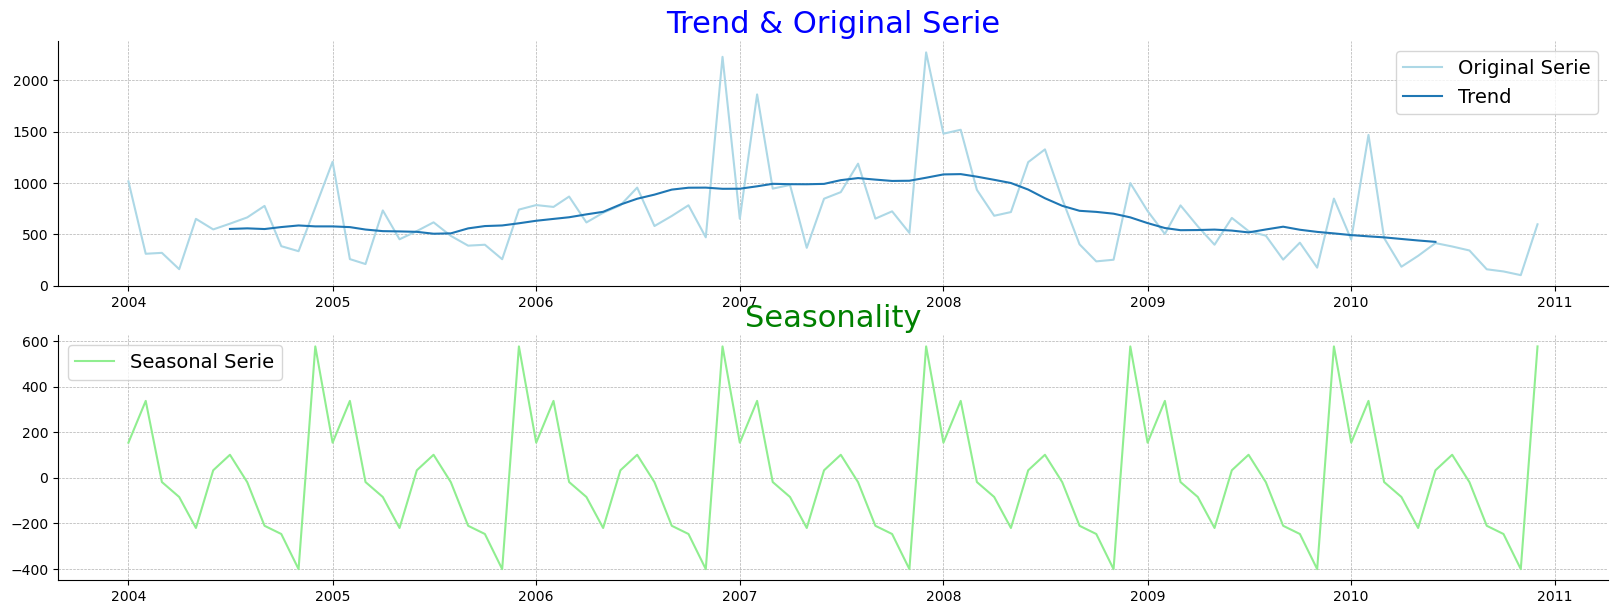

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

united_seas = united.copy()
united_seas.set_index('Date', inplace = True)   # important to set_index the date period

decomposition = seasonal_decompose(united_seas)

trend = decomposition.trend 
seasonal = decomposition.seasonal
residual = decomposition.resid


fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize = (20,7))

ax1.plot(united_seas, label = 'Original Serie', color = 'lightblue')
ax1.plot(trend, label = 'Trend')
ax1.grid(True, ls = '--', lw = 0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Trend & Original Serie', size = 22, color = 'blue')
ax1.legend(fontsize = 14)

ax2.plot(seasonal, label = 'Seasonal Serie', c = 'lightgreen')
ax2.grid(True, ls = '--', lw = 0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_title('Seasonality', size = 22, color = 'green')
ax2.legend(loc = 'upper left', fontsize = 14)
plt.show()

* **Original Series: Here, we can see significant peaks at certain times, which could indicate seasonal events or outliers. The variability of the series seems quite irregular, with periods of high and low values.**
* **Seasonal Series: This represents the estimated seasonal component of the time series. A pattern can be observed that seems to repeat with some regularity, suggesting seasonality in the data. This seasonality could correspond to fixed periods in the year, like seasons or quarters.**
* **Trend: The trend shows the general long-term movement of the time series, eliminating the effects of seasonality and other irregularities. It is observed that the trend is relatively flat at the beginning, indicating little change over the period, then it begins to gradually decrease after 2007, suggesting a general decline in the value of the time series studied towards the end of the period.**

## ACF - AutoCorrelation

In [6]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lst_acf = acf(united.Cancelled, nlags = 12).tolist()

lst = []
for i, element in enumerate(lst_acf):
    lst.append([f't - {i}', element])
    
df_acf = pd.DataFrame(lst, columns = ['Time', 'ACF'])
df_acf.head()

,Time,ACF
0,t - 0,1.000000
1,t - 1,0.288393
2,t - 2,0.323259
3,t - 3,0.021723
4,t - 4,0.194850


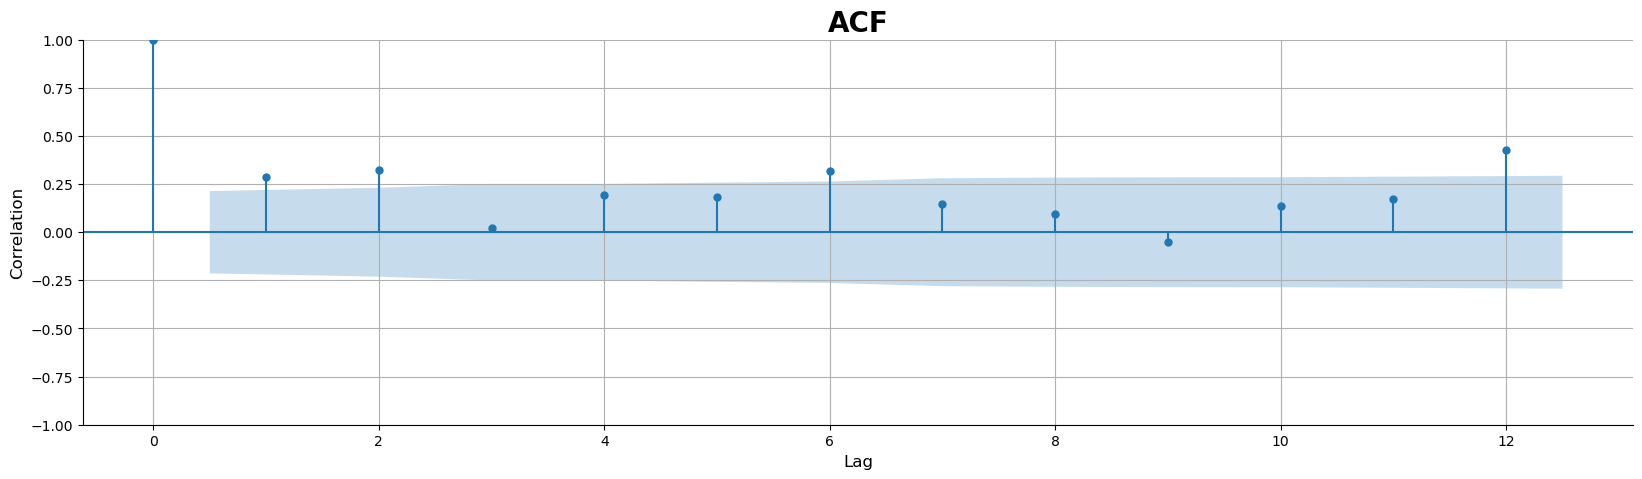

In [7]:
# plot the results
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(united.Cancelled, ax = ax, lags = 12) 
ax.set_ylabel('Correlation', size = 12)
ax.set_xlabel('Lag', size = 12)
ax.set_title('ACF', size = 20, fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.grid(True);

**We can observe that there is a significant and positive autocorrelation between the series and itself at `n-1`, `n-2`, `n-6`, and especially at `n-12` with an ACF of 0.42 (one year back). Regarding the level of stationarity, we can observe a slow decrease at certain levels, which could mean that the series is not stationary.**

## PACF

In [8]:
lst_pacf = pacf(united.Cancelled, nlags = 12).tolist()

lstp = []
for i, element in enumerate(lst_pacf):
    lstp.append([f't - {i}', element])
    
df_pacf = pd.DataFrame(lstp, columns = ['Time', 'PACF'])
df_pacf.head()

,Time,PACF
0,t - 0,1.000000
1,t - 1,0.291868
2,t - 2,0.268860
3,t - 3,-0.149182
4,t - 4,0.172151


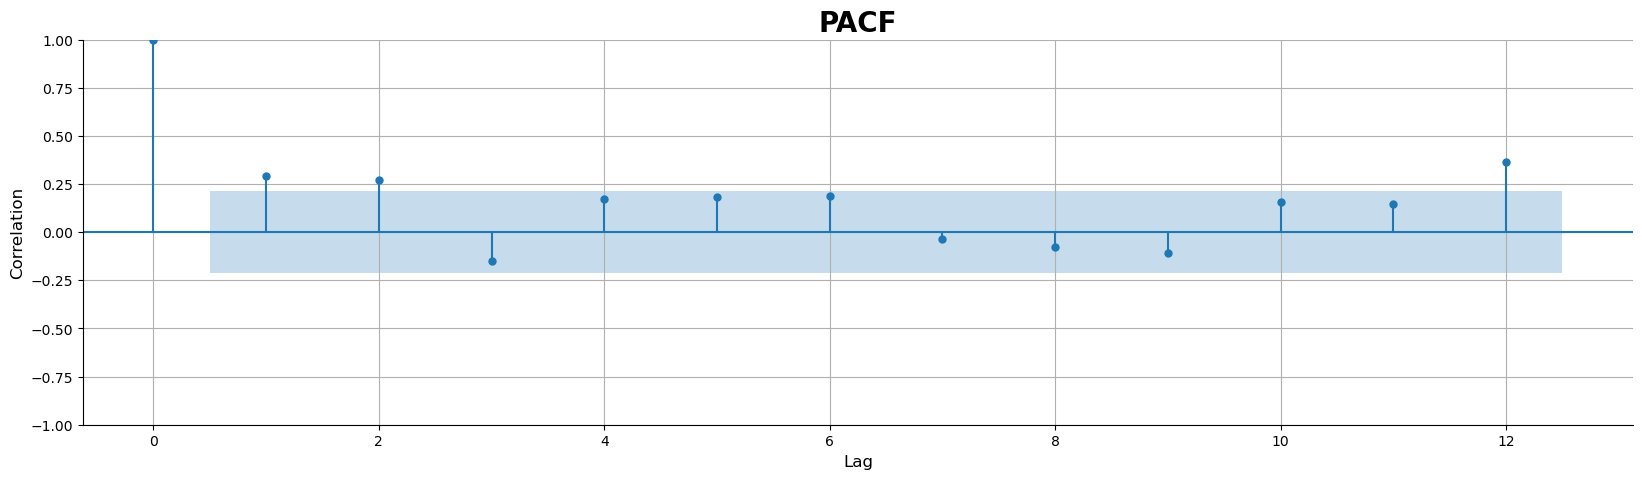

In [9]:
# plot the results
fig, ax = plt.subplots(figsize=(20,5))
plot_pacf(united.Cancelled, ax = ax, lags = 12) 
ax.set_ylabel('Correlation', size = 12)
ax.set_xlabel('Lag', size = 12)
ax.set_title('PACF', size = 20, fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.grid(True);

**Here too, we can see that at a lag of `t-1`, `t-2`, and `t-12`, the series is moderately similar to itself. The difference between ACF and PACF is that ACF takes into account the effects from 1 to t-1, unlike PACF. For example, a PACF of 0.5 at a lag of 3 means that the data is moderately similar to itself three time periods ago, and this without taking into account t-1, t-2.**

In [10]:
df_both = pd.merge(df_acf, df_pacf, on = 'Time', how = 'inner')
df_both.head(10)

,Time,ACF,PACF
0,t - 0,1.000000,1.000000
1,t - 1,0.288393,0.291868
2,t - 2,0.323259,0.268860
3,t - 3,0.021723,-0.149182
4,t - 4,0.194850,0.172151
5,t - 5,0.183977,0.181942
6,t - 6,0.316227,0.187570
7,t - 7,0.145290,-0.035879
8,t - 8,0.092290,-0.074848
9,t - 9,-0.051871,-0.106693


## Dickey-Fuller Test

Certainly, here's the English translation of your text:

**The Dickey-Fuller test is an extremely important statistical test in Time Series analysis that aims to determine whether a time series is stationary, that is, whether its statistical properties such as mean and standard deviation vary over time or not.**

In [11]:
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

fuller_test = adfuller(united.Cancelled)

## Interpretation of Results

- H0 -> Non-stationary Series
- H1 -> Stationary Series

* `Test Statistic`: In the context of the ADF test, if:

    * If the test statistic is lower than the critical value for a confidence level (for example, 5%), then we reject H0. This indicates that the series is stationary.

    * If the test statistic is higher or less negative than the critical value, then we accept H0. This suggests that the series is non-stationary.

* `P-Value`: A high P-value (usually above the 0.05 threshold) suggests that we cannot reject the null hypothesis. In our case, the P-value of 0.85 is very high, meaning that there is a strong probability that our time series is non-stationary.

In [12]:
table = [['Test Statistic', fuller_test[0]],
         ['P_Value', fuller_test[1]],
         ['Confidence interval of 5%', fuller_test[4].get('5%')],
         ['Conclusion', 'Stationary Serie' if fuller_test[1] < 0.05 else 'Non-stationary Series']]

print(tabulate(table, headers = ['Metrics', 'Values'], tablefmt = 'github'))

| Metrics                   | Values                |
|---------------------------|-----------------------|
| Test Statistic            | -0.6729874431458974   |
| P_Value                   | 0.8536228899900069    |
| Confidence interval of 5% | -2.9026070739026064   |
| Conclusion                | Non-stationary Series |


**We therefore see that the test statistic is higher than our critical value for 5%, so we accept H0, and thus the series is non-stationary. Similarly, the P-Value is very high, which means that once again we cannot reject H0. Therefore, there is a very high probability that the series is non-stationary.**


# Differentiation - Or How to Make a Series Stationary

The primary goal of differentiation is to render a time series stationary.

**Differentiation allows:**
* Elimination of Trends: If the original time series has a trend (upward or downward), differentiation can help remove it, making the series more stationary.

* Highlighting Changes: Peaks and troughs in the differentiation graph can indicate points in time where there have been significant changes in the data.

**Why is it necessary to make a series stationary?**
* Linear Models: Many time series models, such as ARIMA (AutoRegressive Integrated Moving Average), assume that the time series is stationary. A series is stationary if its statistical properties, such as mean, variance, and autocorrelation, remain constant over time.
* Better Forecasts: Stationary time series are generally easier to model, and the forecasts from these models are more reliable.

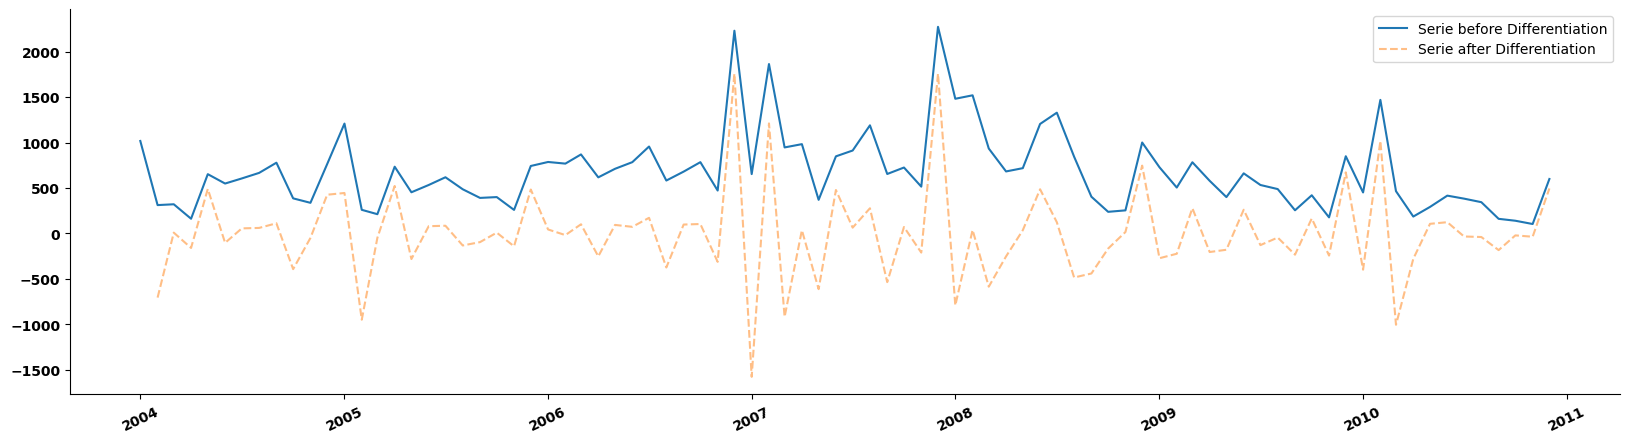

In [13]:
diff = united_seas.Cancelled.diff().dropna()

plt.figure(figsize=(20, 5))
plt.plot(united_seas, label = 'Serie before Differentiation')
plt.plot(diff, label = 'Serie after Differentiation', ls = '--', alpha =0.5)
plt.xticks(fontweight = 'bold', rotation = 25)
plt.yticks(fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()

In [14]:
# test fuller on the differenciation data

k_diff = adfuller(diff)

k_table = [['Test Statistic', k_diff[0]],
         ['P_Value', k_diff[1]],
         ['Confidence interval of 5%', k_diff[4].get('5%')],
         ['Conclusion', 'Stationary Serie' if k_diff[1] < 0.05 else 'Non-stationary Series']]

print(tabulate(k_table, headers = ['Metrics', 'Values'], tablefmt = 'github'))

| Metrics                   | Values               |
|---------------------------|----------------------|
| Test Statistic            | -5.345668640700929   |
| P_Value                   | 4.40081025918062e-06 |
| Confidence interval of 5% | -2.9026070739026064  |
| Conclusion                | Stationary Serie     |


**This time we can see that our Test is lower than our confidence interval and that our P-Value is below 0.05, so we reject H0 and accept H1, indicating that the Series is Stationary.**

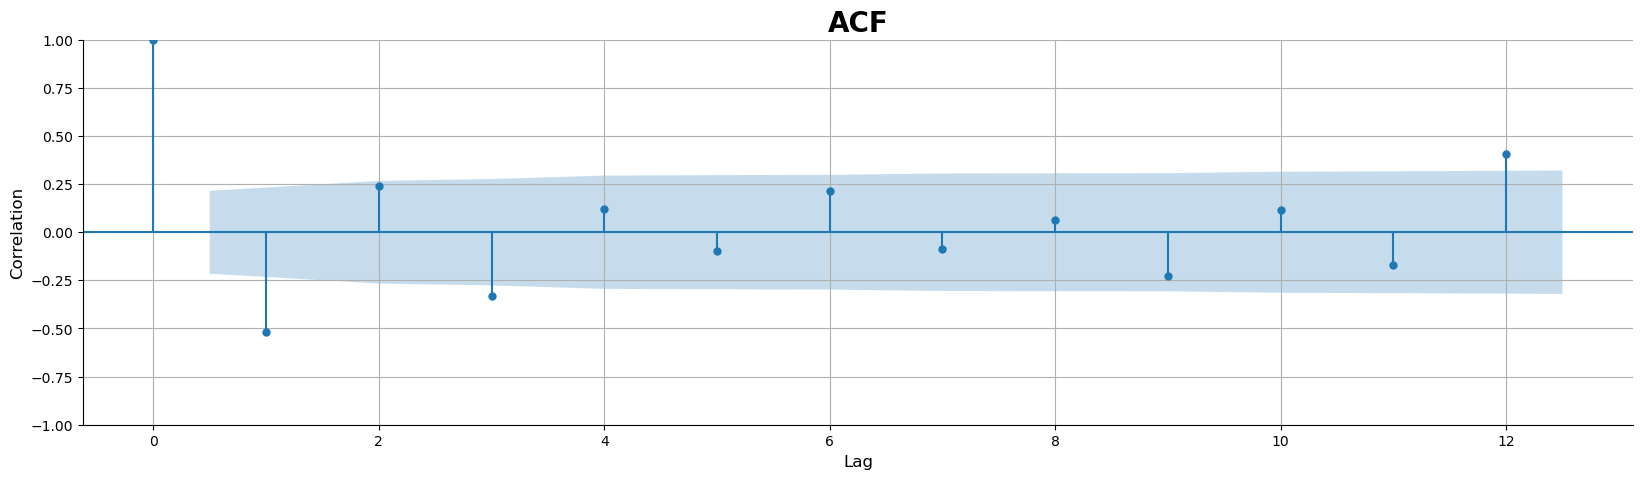

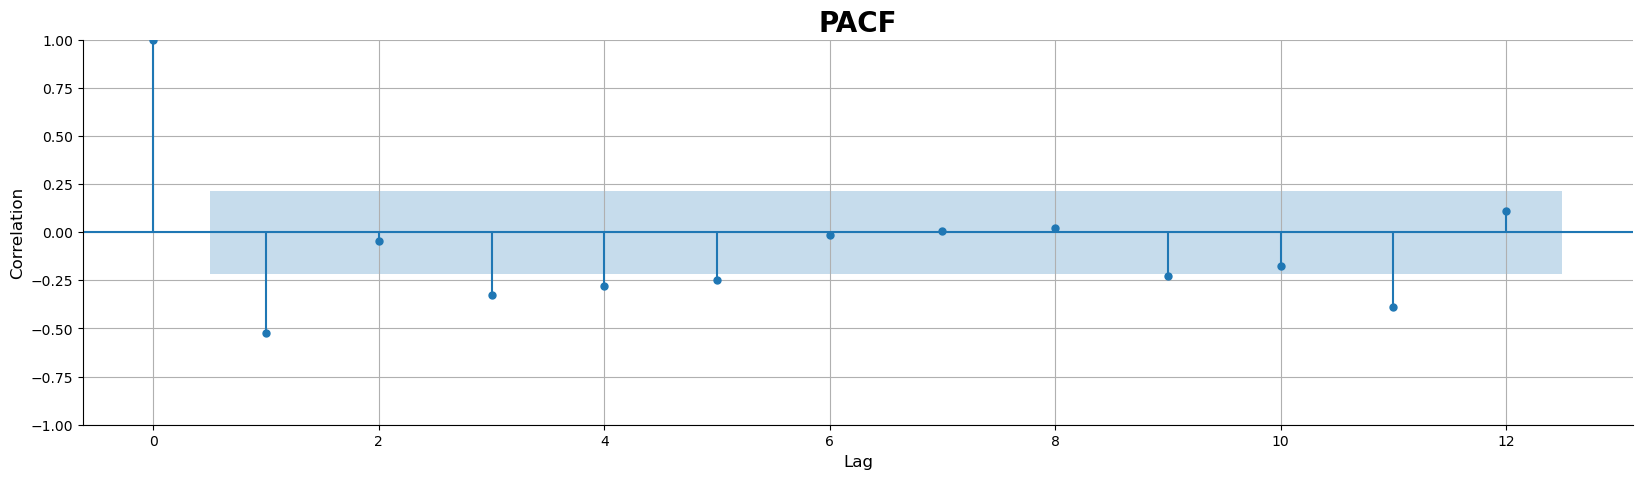

In [15]:
# plot the results
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(diff, ax = ax, lags = 12) 
ax.set_ylabel('Correlation', size = 12)
ax.set_xlabel('Lag', size = 12)
ax.set_title('ACF', size = 20, fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.grid(True);

# plot the results
fig, ax = plt.subplots(figsize=(20,5))
plot_pacf(diff, ax = ax, lags = 12) 
ax.set_ylabel('Correlation', size = 12)
ax.set_xlabel('Lag', size = 12)
ax.set_title('PACF', size = 20, fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.grid(True);

**Nous pouvons cette fois observer qu'il n'y a plus cette "decroissance" est que la série parait bien stationnaire**

# Arima

**Parameters: `d`, `p`, `q`**

* `d` -> Number of differentiations.
* `p` -> Number of lags of the Series that are used to predict the current value. For example, if `p = 2`, the model will use the two previous values to predict the current value (two months back for each prediction in this example).

**Well, now that we have our value `d`, which signifies the differentiation and is therefore 1 (in cases where our series is still not stationary after our first differentiation, we could potentially do a second one, but it is advised not to do more), we need to find the `p`. We can find this parameter with the help of PACF.**


### PACF - Identification of `p`

* Let's observe the peaks: Each vertical bar represents the partial correlation at that specific lag. If a bar exceeds the upper threshold line, this indicates a positive or significant correlation. If it goes below the lower threshold line, this indicates a significant negative correlation.
* Determine the last significant lag: The last peak that exceeds the threshold lines, whether positive or negative, indicates the last significant lag. The number of this lag is our estimation of `p`. The last significant consecutive peak in the PACF gives you an estimation of p, but you need to be cautious interpreting isolated peaks that appear after a space of insignificant lags.

**Conclusion:** There are 1 consecutive significant peaks in our PACF chart, so: `p=1`


### ACF - Identification of `q`

First, we need to differentiate (once or more, max 2 times), if our series is not already stationary. After differentiating our series, we observe the `ACF` graph, then:
* Count of significant peaks -> The number of consecutive significant peaks **before the ACF falls within the confidence bands** (these lines generally represent a 95% confidence threshold) can be an indication of the `q` parameter for the model. For example, if we see two significant peaks before the ACF drops below the threshold, this suggests a `q = 2`.

**Conclusion:** We see in our ACF chart that we have 1 peak before falling into the confidence interval, so: `q=1`

In [17]:
# split data
train_data = diff[ :  int(diff.shape[0] -  diff.shape[0] * 0.2)]
test_data = diff[ int(diff.shape[0] -  diff.shape[0] * 0.2):]

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

d = 1
p = 1
q = 1

model = ARIMA(train_data, order = (p, d, q))
model_fitted = model.fit()

In [28]:
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:              Cancelled   No. Observations:                   66
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -491.218
Date:                Thu, 07 Mar 2024   AIC                            988.436
Time:                        01:00:59   BIC                            994.959
Sample:                    02-01-2004   HQIC                           991.010
                         - 07-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5182      0.115     -4.506      0.000      -0.744      -0.293
ma.L1         -0.9998      0.118     -8.482      0.000      -1.231      -0.769
sigma2      2.001e+05   5.92e-07   3.38e+11      0.0

## Evaluation

**After training our model, it is essential to check its quality. This includes verifying the residuals. The residuals are what remain (the difference) between the true values and the values observed by the model. The residuals are denoted epsilon**

$$
\LARGE \mathbb{E}(\theta - \hat{\theta}) = \mathbb{E}(f(x) + \epsilon - f(\hat{x}))
$$

**If our model is well-fitted, the residuals (which will be present even if the model makes perfect predictions), must behave like white noise (meaning they are just due to chance and not to the quality of the model). In summary, if our residuals are white noise, it means that the model has captured all the rules or trends in the data, and all that remains is the randomness that we cannot predict.**


### Ljung-Box Test
**To know if the residuals of our predictions behave like white noise, we can use the Ljung-Box test. After performing the test, if the p-value is higher than a certain threshold (often 0.05), it means that the residuals can be considered as white noise. We can see in the test above that the P-Value of the Ljung-Box test is 0.97, so the residuals can be considered as white noise.**

### Heteroskedasticity (H)

**Heteroskedasticity refers to the situation where the variability of the residue is not constant across all observations. We always prefer to have a constant prediction error, which is why heteroskedasticity is important. A good model should exhibit heteroskedasticity, in other words, a constant variance of the residuals. A value above 1 suggests a certain presence of heteroskedasticity.**


### Normality 
In a good model, we expect the residuals to follow a normal distribution. The Jarque-Bera test is a hypothesis test that seeks to determine if data follow a normal distribution. 

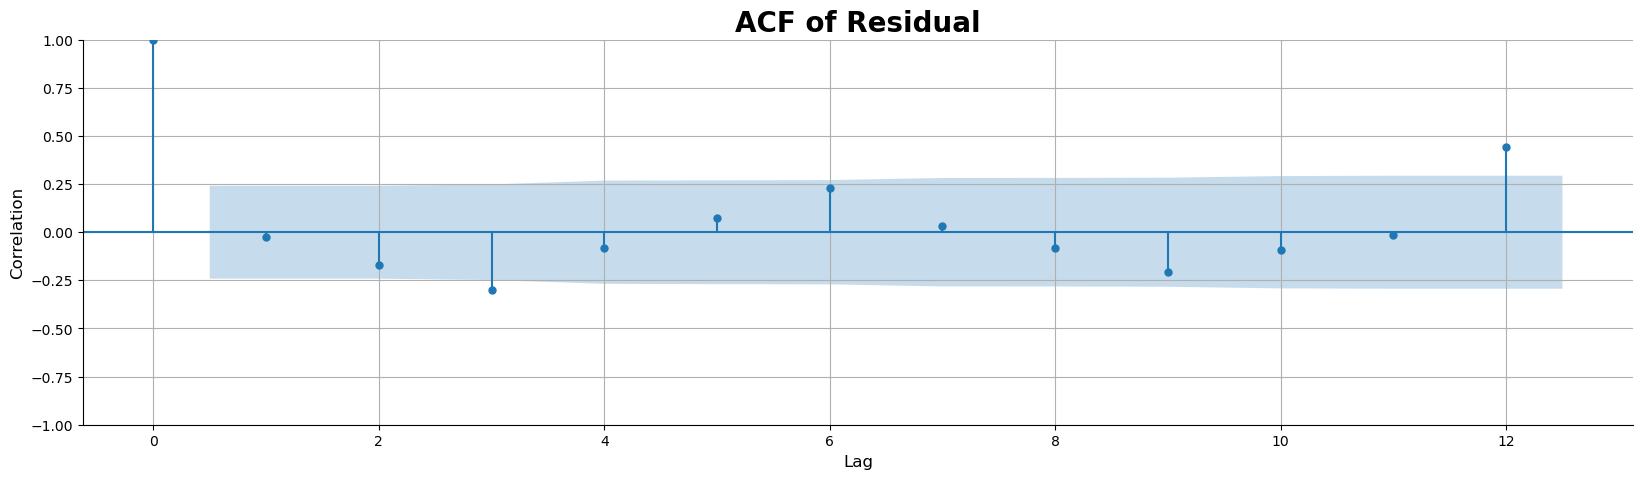

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals_fitted = model_fitted.resid

# plot the ACF of the model's residual
fig, ax = plt.subplots(figsize=(20,5))
plot_acf(residuals_fitted, ax = ax, lags = 12) 
ax.set_ylabel('Correlation', size = 12)
ax.set_xlabel('Lag', size = 12)
ax.set_title('ACF of Residual', size = 20, fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.grid(True);

**Globalement je peux dire que les résidus sont des bruits blanc car les pics se trouvent principalement dans la zone de confiance.**

# Prediction

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_predict = model_fitted.predict(start = train_data.index[0], end = train_data.index[-1]) # from -> to (date)

test_predict = model_fitted.predict(start = test_data.index[0], end = test_data.index[-1])

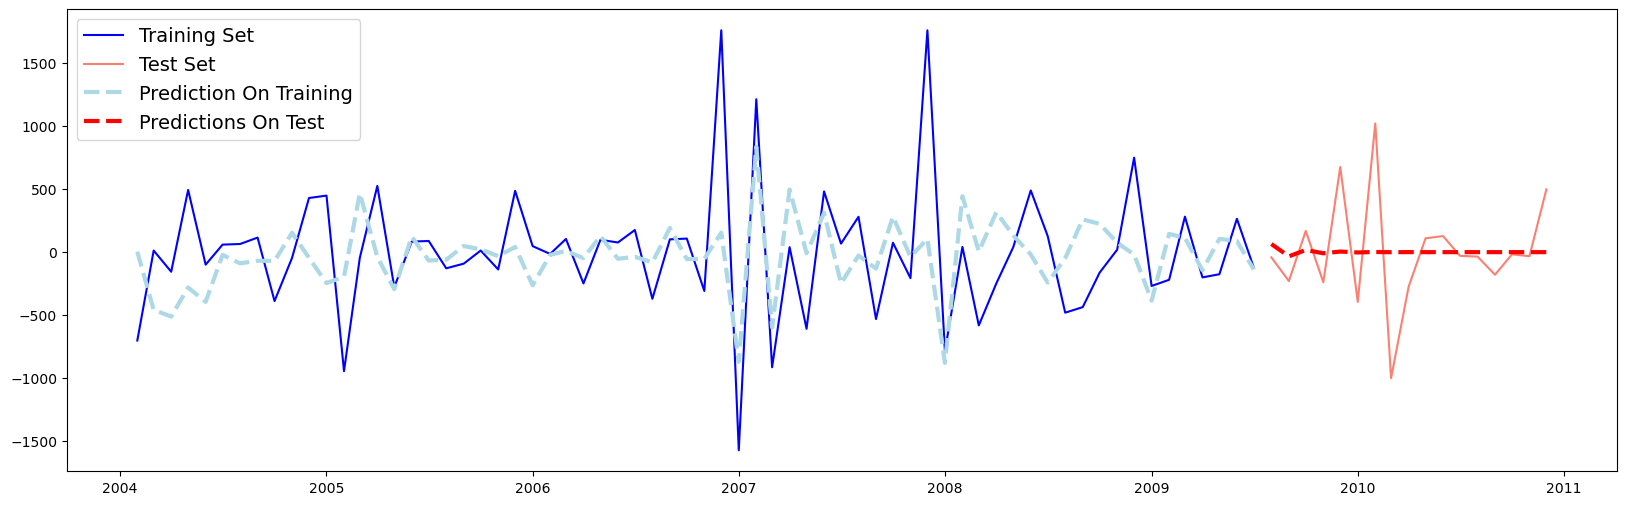

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(train_data.index, train_data.values, label = 'Training Set', color = 'blue')
plt.plot(test_data.index, test_data.values, label = 'Test Set', color = 'salmon')
plt.plot(train_predict.index, train_predict.values, label = 'Prediction On Training', color = 'lightblue', ls = '--', lw = 3)
plt.plot(test_predict.index, test_predict.values, label = 'Predictions On Test', color = 'red', ls = '--', lw = 3)
plt.legend(fontsize = 14)
plt.show()

In [23]:
# my own evaluation
lst_total = []

for real, predict in zip(test_data.values,test_predict.values):
    lst_total.append([int(real), round(predict, 2)])
    
final = pd.DataFrame(lst_total, columns = ['Real', 'Predict'])
final = pd.concat([test_data.index.to_series().reset_index(drop=True),final], axis = 1)
final['Difference'] = abs(final.Real - final.Predict)
print(f'Difference Mean: {final.Difference.mean():.2f}')
print(f'Std Predict: {final.Predict.std()}')
print(f'Std Real: {final.Real.std()}')
final.head()

Difference Mean: 298.35
Std Predict: 18.657509192405776
Std Real: 446.09232261283944


,Date,Real,Predict,Difference
0,2009-08-01,-45,60.77,105.77
1,2009-09-01,-233,-37.05,195.95
2,2009-10-01,165,13.64,151.36
3,2009-11-01,-243,-12.63,230.37
4,2009-12-01,672,0.98,671.02


In [24]:
print(f'The MSE on Train Data is: {mean_squared_error(y_true = train_data, y_pred = train_predict)} ')
print(f'The MSE on Test Data is: {mean_squared_error(y_true = test_data, y_pred = test_predict)}')

The MSE on Train Data is: 216033.2765950536 
The MSE on Test Data is: 185804.50217756024


## Optimization

In [29]:
# split data
train_data = diff[ :  int(diff.shape[0] -  diff.shape[0] * 0.2)]
test_data = diff[ int(diff.shape[0] -  diff.shape[0] * 0.2):]

In [30]:
import warnings
warnings.filterwarnings('ignore')
# trend : str{'n','c','t','ct'} 
lst_opti = []

p_range = range(0, 15)
d_range = range(1, 2)   # we did only one differenciation
q_range = range(0, 15)


for p in p_range:
    for d in d_range:
        for q in q_range:
            
            order = (p, d, q)
            model = ARIMA(train_data, order=order).fit()
            prediction = model.predict(start=test_data.index[0], end=test_data.index[-1])
            mse = mean_squared_error(y_true = test_data, y_pred=prediction)
            lst_opti.append({'order': order, 'MSE': mse})

In [31]:
results_df = pd.DataFrame(lst_opti)
results_df = results_df.sort_values(by='MSE').reset_index(drop = True)
results_df.head()

,order,MSE
0,"(3, 1, 13)",103452.232795
1,"(9, 1, 4)",119899.170804
2,"(4, 1, 14)",125410.703292
3,"(6, 1, 7)",125749.638356
4,"(10, 1, 11)",129164.102822


In [32]:
new_model = ARIMA(train_data, order = results_df.iloc[0].order).fit()

In [33]:
prediction_new = new_model.predict(start = test_data.index[0], end = test_data.index[-1])

In [34]:
# my own evaluation
lst_total = []

for real, predict in zip(test_data.values,prediction_new.values):
    lst_total.append([int(real), round(predict, 2)])
    
final = pd.DataFrame(lst_total, columns = ['Real', 'Predict'])
final = pd.concat([test_data.index.to_series().reset_index(drop=True),final], axis = 1)
final['Difference'] = abs(final.Real - final.Predict)
print(f'Difference Mean: {final.Difference.mean():.2f}')
print(f'Std Predict: {final.Predict.std()}')
print(f'Std Real: {final.Real.std()}')
final.head()

Difference Mean: 200.40
Std Predict: 236.23938710989503
Std Real: 446.09232261283944


,Date,Real,Predict,Difference
0,2009-08-01,-45,80.25,125.25
1,2009-09-01,-233,-466.86,233.86
2,2009-10-01,165,15.01,149.99
3,2009-11-01,-243,-266.63,23.63
4,2009-12-01,672,542.20,129.80


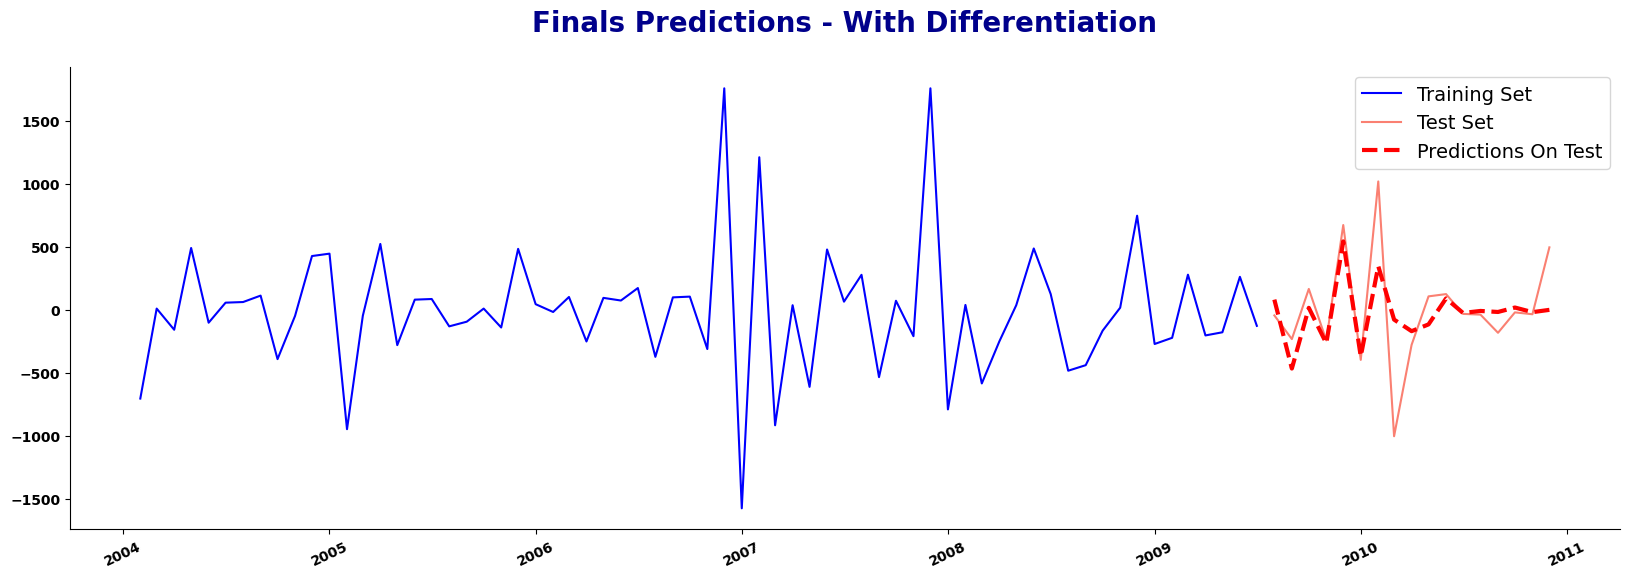

In [40]:
plt.figure(figsize=(20, 6))
plt.plot(train_data.index, train_data.values, label = 'Training Set', color = 'blue')
plt.plot(test_data.index, test_data.values, label = 'Test Set', color = 'salmon')
plt.plot(prediction_new.index, prediction_new.values, label = 'Predictions On Test', color = 'red', ls = '--', lw = 3)
plt.legend(loc = 0, frameon = True, fontsize = 14)
plt.title('Finals Predictions - With Differentiation', fontsize = 20, color = 'darkblue', fontweight = 'bold', y = 1.06)
plt.xticks(fontweight = 'bold', rotation = 25)
plt.yticks(fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Drop the Differenciation - To get logical predictions

**To remove the differentiation, we need to add each predicted differentiated value to the previous non-differentiated actual value to obtain the reintegrated value.**

**french - Pour retirer la différentation nous devons additionner chaque valeur prédite différenciée avec la valeur réelle non différenciée précédente pour obtenir la valeur réintégrée**



In [36]:
final['RealNoDiff'] = list(united_seas[ int(diff.shape[0] -  diff.shape[0] * 0.2) + 1:].Cancelled.values)

In [37]:
# Correction de la méthode de réintégration en utilisant la valeur réelle non différenciée précédente
real_no_diff_corrected = [final['RealNoDiff'][0]]  # Première valeur réelle non différenciée

for i in range(1, len(final)):
    new_value = final['RealNoDiff'][i-1] + final['Predict'][i]
    real_no_diff_corrected.append(new_value)

# Ajout des valeurs réintégrées corrigées au dataframe
final['RealNoDiffCorrected'] = real_no_diff_corrected

In [38]:
final.head()

,Date,Real,Predict,Difference,RealNoDiff,RealNoDiffCorrected
0,2009-08-01,-45,80.25,125.25,488,488.00
1,2009-09-01,-233,-466.86,233.86,255,21.14
2,2009-10-01,165,15.01,149.99,420,270.01
3,2009-11-01,-243,-266.63,23.63,177,153.37
4,2009-12-01,672,542.20,129.80,849,719.20


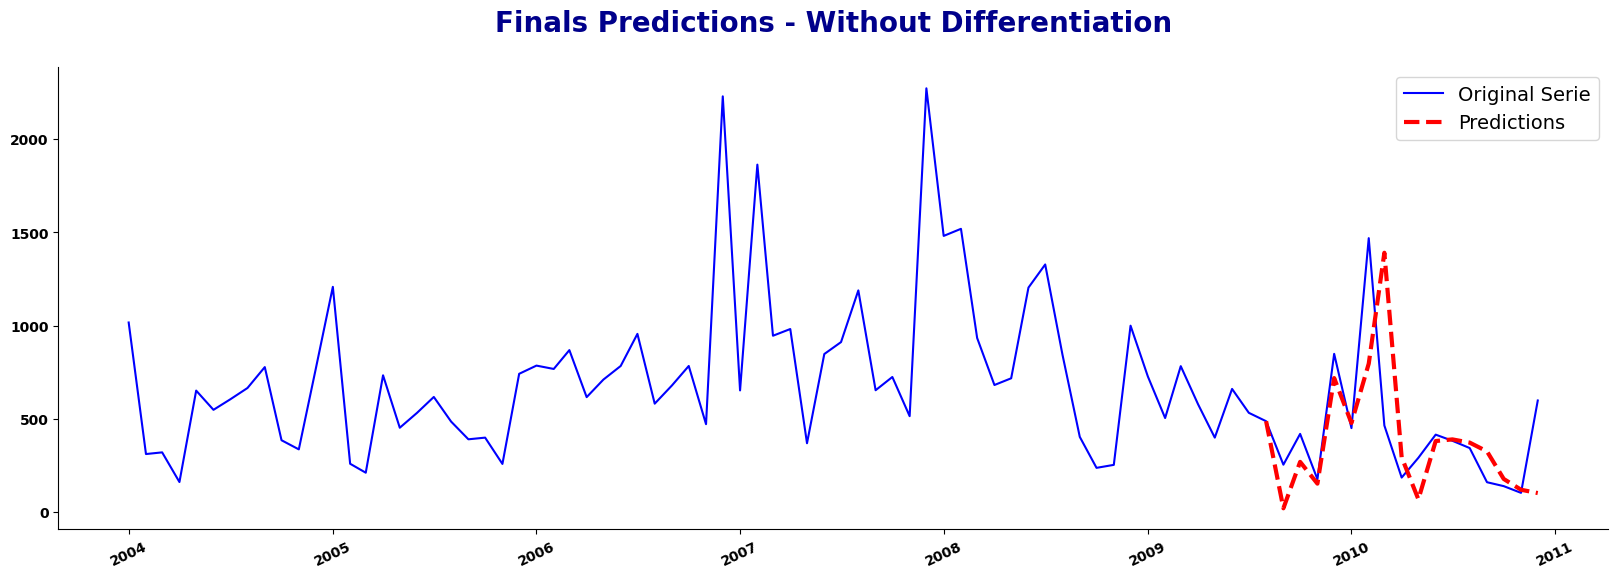

In [41]:
plt.figure(figsize=(20, 6))
plt.plot(united_seas.index, united_seas.values, label = 'Original Serie', color = 'blue')
plt.plot(final.Date, final.RealNoDiffCorrected, label = 'Predictions', color = 'red', ls = '--', lw = 3)
plt.legend(loc = 0, frameon = True, fontsize = 14)
plt.title('Finals Predictions - Without Differentiation', fontsize = 20, color = 'darkblue', fontweight = 'bold', y = 1.06)
plt.xticks(fontweight = 'bold', rotation = 25)
plt.yticks(fontweight = 'bold')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()